In [47]:
# ! pip install -U imbalanced-learn
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
from scipy.sparse import issparse
from asgmnt_2_tools import lazy_read_parquet
from imblearn.under_sampling import RandomUnderSampler

#### Read in example data file using read parquet

In [48]:
root_path = "../../Data/GoogleDrive/"
df_dict_all = lazy_read_parquet(root_path)
df_heart_drop_05_imp = df_dict_all['df_heart_drop_05_imp'].collect().to_pandas()
df_heart_drop_05_imp

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,...,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartDisease
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,No,...,1.70,81.19,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
1,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,No,...,1.60,68.04,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,None of them,No,...,1.57,63.50,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,Yes,...,1.65,63.50,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.57,53.98,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394695,Virgin Islands,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,Yes,...,1.65,69.85,Yes,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
394696,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.70,83.01,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
394697,Virgin Islands,Female,Poor,30.0,30.0,5 or more years ago,No,5.0,1 to 5,No,...,1.70,49.90,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
394698,Virgin Islands,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,None of them,Yes,...,1.83,108.86,No,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,Yes


In [33]:
df_heart_drop_05_imp['State'].value_counts()

Washington              23497
New York                15061
Minnesota               14821
Ohio                    14256
Maryland                13882
Texas                   12180
Florida                 11363
Kansas                  10247
Maine                   10117
Massachusetts           10116
Wisconsin                9867
California               9273
Virginia                 9199
Arizona                  8869
Utah                     8853
Indiana                  8842
Michigan                 8608
South Carolina           8492
Colorado                 8398
Iowa                     8241
Connecticut              8183
Georgia                  7846
Vermont                  7708
South Dakota             7182
Hawaii                   7107
Missouri                 6993
Nebraska                 6898
Montana                  6639
New Jersey               6637
Idaho                    5958
New Hampshire            5874
Oregon                   5449
Puerto Rico              5409
Alaska    

In [16]:
# getting classes in ordinal variables
print(df_heart_drop_05_imp['GeneralHealth'].unique())
print(df_heart_drop_05_imp['LastCheckupTime'].unique())
print(df_heart_drop_05_imp['RemovedTeeth'].unique())
print(df_heart_drop_05_imp['SmokerStatus'].unique())
print(df_heart_drop_05_imp['ECigaretteUsage'].unique())
print(df_heart_drop_05_imp['AgeCategory'].unique())
# print(df_heart_drop_imp['TetanusLast10Tdap'].unique())
print(df_heart_drop_05_imp.info(max_cols=len(df_heart_drop_05_imp.columns)))

['Very good' 'Excellent' 'Fair' 'Poor' 'Good']
['Within past year (anytime less than 12 months ago)'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)'
 '5 or more years ago']
['None of them' '1 to 5' '6 or more, but not all' 'All']
['Never smoked' 'Current smoker - now smokes some days' 'Former smoker'
 'Current smoker - now smokes every day']
['Not at all (right now)' 'Never used e-cigarettes in my entire life'
 'Use them every day' 'Use them some days']
['Age 80 or older' 'Age 55 to 59' 'Age 65 to 69' 'Age 40 to 44'
 'Age 75 to 79' 'Age 70 to 74' 'Age 60 to 64' 'Age 50 to 54'
 'Age 45 to 49' 'Age 35 to 39' 'Age 30 to 34' 'Age 25 to 29'
 'Age 18 to 24']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394700 entries, 0 to 394699
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      394700 non-nu

#### Under sampling to balance data

distribution of yes and no in target before under sampling

No     347430
Yes     47270
Name: HadHeartDisease, dtype: int64


<AxesSubplot:ylabel='HadHeartDisease'>

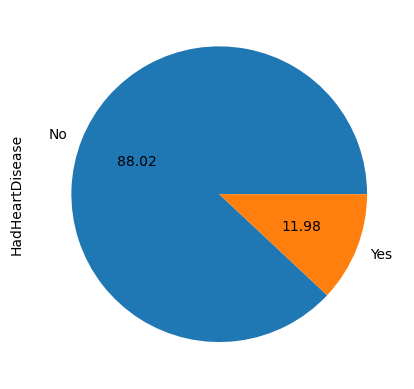

In [52]:
X = df_heart_drop_05_imp.drop('HadHeartDisease', axis=1)
y = df_heart_drop_05_imp['HadHeartDisease']
print(y.value_counts())
y.value_counts().plot.pie(autopct='%.2f')

Function for under sampling

In [53]:
# Only balance the training set
def balance(df):
    
    # Define the features and target
    X = df.drop('HadHeartDisease', axis=1)
    y = df['HadHeartDisease']
    yes_count = y.value_counts()[1]
    no_count = yes_count * 3
    sampling_strategy = {'No': no_count, 'Yes': yes_count}  # A 3:1 ratio
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy) 
    X_res, y_res = rus.fit_resample(X, y)
    return X_res, y_res

Distribution of yes and no in target after under sampling

No     141810
Yes     47270
Name: HadHeartDisease, dtype: int64


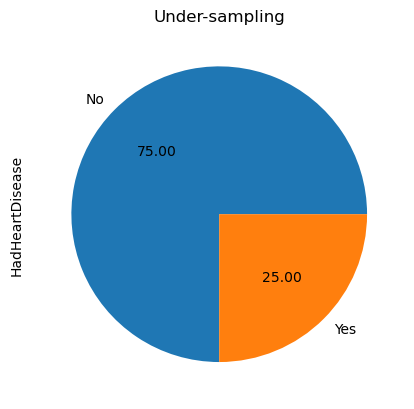

In [54]:
X_res, y_res = balance(df_heart_drop_05_imp)
print(y_res.value_counts())
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

#### Encoding and data split

In [55]:
def encode(X_res, y_res):
    """
    Encodes the dataset using one-hot encoding for general categorical columns and 
    ordinal encoding for specified columns with predefined categories. Splits the data into training and test datasets.

    Parameters:
        df (pandas.DataFrame): DataFrame to encode and split.

    Returns:
      X_train_encoded (DataFrame): Encoded training features.
      X_test_encoded (DataFrame): Encoded test features.
      y_train (Series): Training target variable.
      y_test (Series): Test target variable.

    """
    # convert health days from float to int
    # df['PhysicalHealthDays'] = df['PhysicalHealthDays'].astype(int)
    # df['MentalHealthDays'] = df['MentalHealthDays'].astype(int)
    
    # data split
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                        test_size = 0.25, 
                                        random_state = 69,
                                        stratify = y_res)

    # Define which columns to one-hot encode and which to label encode
    categorical_cols = X_res.select_dtypes(include=['object']).columns
    one_hot_cols = categorical_cols.drop(['GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 
                                          'AgeCategory', 'SmokerStatus', 'ECigaretteUsage'])
    
    # define the columns with specific encoding
    comp_labels = {
        "GeneralHealth": ['Poor', 'Fair', 'Good', 
                          'Very good', 'Excellent'],

        "LastCheckupTime": ['5 or more years ago',
                            'Within past 5 years (2 years but less than 5 years ago)',
                            'Within past 2 years (1 year but less than 2 years ago)',
                            'Within past year (anytime less than 12 months ago)'],

        "RemovedTeeth": ['None of them', '1 to 5',
                         '6 or more, but not all', 'All'],

        "SmokerStatus": ['Never smoked', 'Former smoker',
                         'Current smoker - now smokes some days',
                         'Current smoker - now smokes every day'],
                         
        "ECigaretteUsage": ['Never used e-cigarettes in my entire life',
                            'Not at all (right now)',
                            'Use them some days',
                            'Use them every day']
    }

    label_encoders = [(key + '_label', OrdinalEncoder(categories=[value]), [key]) 
                      for key, value in comp_labels.items()]
    
    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), one_hot_cols),
            ('label', OrdinalEncoder(), ['AgeCategory']),
        ] + label_encoders
        , remainder='passthrough'
    )
    
    # Fit the preprocessor on the training data only and transform both
    X_train_encoded = preprocessor.fit_transform(X_train)
    X_test_encoded = preprocessor.transform(X_test)

    # fit another label encoder on y
    y_label_encoder = OrdinalEncoder()
    y_train_encoded = y_label_encoder.fit_transform(pd.DataFrame(y_train))
    y_test_encoded = y_label_encoder.transform(pd.DataFrame(y_test))

    # Handle sparse matrix if necessary
    if issparse(X_train_encoded):
        X_train_encoded = X_train_encoded.toarray()
    if issparse(X_test_encoded):
        X_test_encoded = X_test_encoded.toarray()

    # Convert the sparse matrix to DataFrame and specify column names
    X_columns = preprocessor.get_feature_names_out()
    y_column = y_label_encoder.get_feature_names_out()
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=X_columns, index=X_train.index)
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=X_columns, index=X_test.index)
    y_train_encoded = pd.DataFrame(y_train_encoded, columns=y_column, index=y_train.index)
    y_test_encoded = pd.DataFrame(y_test_encoded, columns=y_column, index=y_test.index)
    
    # Remove the state co
    X_train_nostate = X_train_encoded.iloc[:,54:]
    X_test_nostate = X_test_encoded.iloc[:,54:]

    return X_train_nostate, X_test_nostate, y_train_encoded, y_test_encoded


Test encode() on `df_heart_drop_05_imp`

In [56]:
X_train, X_test, y_train, y_test = encode(X_res, y_res)
print(X_train.shape)
print(X_test.shape)
print("=============")
print(y_train.shape)
print(y_test.shape)
print("=============")
print(X_train.info())
print("===================================")
print(y_train.info())

(141810, 121)
(47270, 121)
(141810, 1)
(47270, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 141810 entries, 4642 to 181532
Columns: 121 entries, onehot__State_Alabama to remainder__WeightInKilograms
dtypes: float64(121)
memory usage: 132.0 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 141810 entries, 4642 to 181532
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   HadHeartDisease  141810 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None


Check the y_train and y_test indeed have the right distribution

HadHeartDisease
0.0                106357
1.0                 35453
dtype: int64


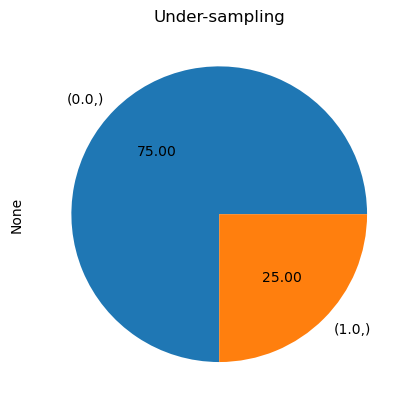

In [57]:
print(y_train.value_counts())
ax = y_train.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

HadHeartDisease
0.0                35453
1.0                11817
dtype: int64


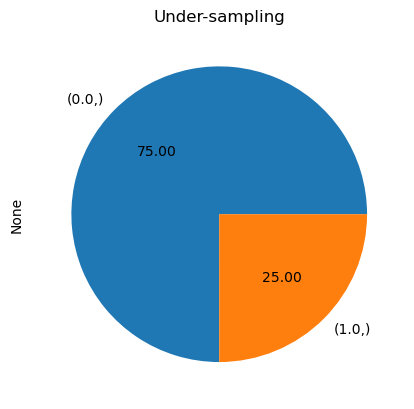

In [58]:
print(y_test.value_counts())
ax = y_test.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

#### Threshold Selection

In [59]:
# use logistic regression to select threshold
def logi_reg(X_train, X_test, y_train, y_test):
    """You know what it does 

        Input: 
            X_train: Encoded features in the training set, a pandas dataframe
            X_test: Encoded features in the test set, a pandas dataframe
            y_train: Target variable of the training set, a pandas series
            y_train: Target variable of the training set, a pandas series

        Output:
            classification_report:
            confusion_matrix:
            accuracy_score:
            roc_auc_score:
    """

    # fit logistic regression model with elastic net regularization
    log_reg = LogisticRegression(penalty = 'elasticnet',
                                solver = 'saga',
                                l1_ratio = 0.5,
                                max_iter = 1000,
                                random_state = 69)
    
    log_reg.fit(X_train, y_train)

    # predict on test set
    y_test_pred = log_reg.predict(X_test)
    y_pred_proba = log_reg.predict_proba(X_test)[:,1]

    # Evaluate performance
    report = classification_report(y_test, y_test_pred, target_names= ['No', 'Yes'])
    matrix = confusion_matrix(y_test, y_test_pred)
    accuracy = accuracy_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return report, matrix, accuracy, roc_auc


Test if under sampling improves performance on one dataset

In [44]:
report, matrix, accuracy, roc_auc = logi_reg(X_train, X_test, y_train, y_test)
print (f"The threshold for removing NAs is 5")
print('\n===============================\n'+
    'Classification report on test data' +
    '\n===============================\n')
print(report)

print('\n===============================\n'+
    'Confusion matrix on test data' +
    '\n===============================\n')
print(matrix)

print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("=====================================\n")

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The threshold for removing NAs is 5

Classification report on test data

              precision    recall  f1-score   support

          No       0.84      0.92      0.88     35453
         Yes       0.65      0.46      0.54     11817

    accuracy                           0.80     47270
   macro avg       0.74      0.69      0.71     47270
weighted avg       0.79      0.80      0.79     47270


Confusion matrix on test data

[[32568  2885]
 [ 6411  5406]]
Accuracy: 0.8033425005288767
ROC AUC: 0.8426982534526393



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AUC improved.

#### Run a loop over thresholds and print out evaluation

Apply `encode()`, `balance()` and `logi_reg()` on all datasets and see which one has best performance

In [60]:
root_path = "../../Data/GoogleDrive/"
df_dict_all = lazy_read_parquet(root_path)
thresholds = [0, 1, 3, 5, 10, 20, 40]
# for creating plots later
roc_list = []
for threshold in thresholds:
    # loop through each dataset
    df = df_dict_all[f'df_heart_drop_{threshold:02}_imp'].collect().to_pandas()
    # under sampling to training set
    X_res, y_res = balance(df)
    # split and encode
    X_train, X_test, y_train, y_test = encode(X_res, y_res)
    # run logistic regression
    report, matrix, accuracy, roc_auc = logi_reg(X_train, X_test, y_train, y_test)
    roc_list.append(roc_auc)
    print (f"The threshold for removing NAs is {threshold:02}")
    print('Shape of the dataset: ' + str(df.shape))
    print('\n===============================\n'+
        'Classification report on test data' +
        '\n===============================\n')
    print(report)

    print('\n===============================\n'+
        'Confusion matrix on test data' +
        '\n===============================\n')
    print(matrix)

    print("Accuracy:", accuracy)
    print("ROC AUC:", roc_auc)
    print("=====================================\n")

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 00
Shape of the dataset: (248265, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.83      0.92      0.87     21860
         Yes       0.64      0.45      0.53      7286

    accuracy                           0.80     29146
   macro avg       0.74      0.68      0.70     29146
weighted avg       0.79      0.80      0.79     29146


Confusion matrix on test data

[[20026  1834]
 [ 3980  3306]]
Accuracy: 0.8005215123859192
ROC AUC: 0.8402823321820113



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 01
Shape of the dataset: (342961, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.83      0.92      0.87     30396
         Yes       0.65      0.45      0.53     10132

    accuracy                           0.80     40528
   macro avg       0.74      0.69      0.70     40528
weighted avg       0.79      0.80      0.79     40528


Confusion matrix on test data

[[27931  2465]
 [ 5532  4600]]
Accuracy: 0.8026796288985393
ROC AUC: 0.8431334591056951



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 03
Shape of the dataset: (387487, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.84      0.92      0.87     34697
         Yes       0.65      0.46      0.54     11566

    accuracy                           0.80     46263
   macro avg       0.74      0.69      0.71     46263
weighted avg       0.79      0.80      0.79     46263


Confusion matrix on test data

[[31808  2889]
 [ 6268  5298]]
Accuracy: 0.8020664461880985
ROC AUC: 0.8416825518629445



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 05
Shape of the dataset: (394700, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.83      0.91      0.87     35453
         Yes       0.64      0.46      0.53     11817

    accuracy                           0.80     47270
   macro avg       0.74      0.68      0.70     47270
weighted avg       0.79      0.80      0.79     47270


Confusion matrix on test data

[[32392  3061]
 [ 6431  5386]]
Accuracy: 0.7991961074677385
ROC AUC: 0.8392490624990325



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 10
Shape of the dataset: (412908, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.83      0.92      0.87     37109
         Yes       0.65      0.45      0.53     12370

    accuracy                           0.80     49479
   macro avg       0.74      0.68      0.70     49479
weighted avg       0.79      0.80      0.79     49479


Confusion matrix on test data

[[34085  3024]
 [ 6856  5514]]
Accuracy: 0.8003193273914185
ROC AUC: 0.8399477860596086



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The threshold for removing NAs is 20
Shape of the dataset: (439673, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.83      0.92      0.87     39165
         Yes       0.65      0.45      0.53     13055

    accuracy                           0.80     52220
   macro avg       0.74      0.68      0.70     52220
weighted avg       0.79      0.80      0.79     52220


Confusion matrix on test data

[[35979  3186]
 [ 7236  5819]]
Accuracy: 0.8004212945231712
ROC AUC: 0.8370922947591877



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The threshold for removing NAs is 40
Shape of the dataset: (439952, 37)

Classification report on test data

              precision    recall  f1-score   support

          No       0.83      0.92      0.87     39192
         Yes       0.65      0.45      0.53     13064

    accuracy                           0.80     52256
   macro avg       0.74      0.68      0.70     52256
weighted avg       0.79      0.80      0.79     52256


Confusion matrix on test data

[[36026  3166]
 [ 7248  5816]]
Accuracy: 0.8007118799755052
ROC AUC: 0.8387492879747133



/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [61]:
roc_list

[0.8402823321820113,
 0.8431334591056951,
 0.8416825518629445,
 0.8392490624990325,
 0.8399477860596086,
 0.8370922947591877,
 0.8387492879747133]

#### Bar Plot of ROC AUC against thresholds

roc auc as y-axis, thresholds as x-axis

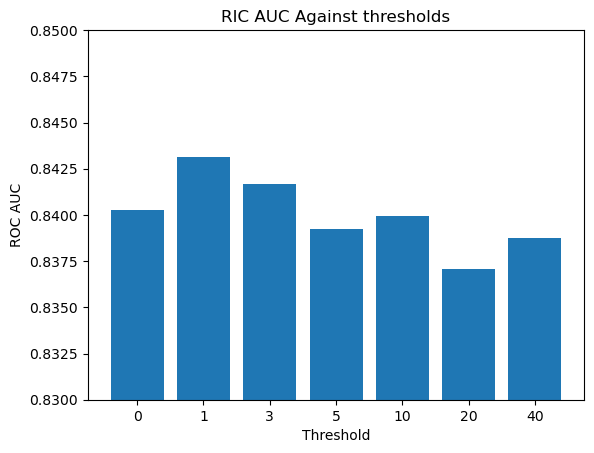

In [62]:
thresholds = [str(threshold) for threshold in thresholds]
# Create bar plot
plt.bar(thresholds, roc_list)
plt.ylim(0.83, 0.85)

# Adding the title and labels
plt.title('RIC AUC Against thresholds')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC')

# Show the plot
plt.show()

Threshold = 5 results the best performance on logit.

#### Reapply encode() on the final dataset again and export

In [63]:
df_heart_drop_01_imp = df_dict_all['df_heart_drop_01_imp'].collect().to_pandas()
df_heart_drop_01_imp

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,...,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartDisease
0,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.57,53.98,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
1,Alabama,Male,Poor,1.0,0.0,Within past year (anytime less than 12 months ...,No,7.0,None of them,No,...,1.80,84.82,No,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,Yes
2,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.65,62.60,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
3,Alabama,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,No,...,1.63,73.48,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No,No
4,Alabama,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,No,...,1.60,59.42,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342956,Virgin Islands,Male,Good,0.0,15.0,Within past year (anytime less than 12 months ...,Yes,7.0,1 to 5,No,...,1.68,83.91,Yes,Yes,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,Yes,Yes
342957,Virgin Islands,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,Yes,...,1.65,69.85,Yes,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
342958,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.70,83.01,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
342959,Virgin Islands,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,None of them,Yes,...,1.83,108.86,No,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,Yes


In [64]:
X_res, y_res = balance(df_heart_drop_01_imp)
X_train, X_test, y_train, y_test = encode(X_res, y_res)

X_train.to_parquet(root_path + "X_train.parquet")
X_test.to_parquet(root_path + "X_test.parquet")
y_train.to_parquet(root_path + "y_train.parquet")
y_test.to_parquet(root_path + "y_test.parquet")

Test read in parquet

In [65]:
root_path = "../../Data/GoogleDrive/"
X_train = pd.read_parquet(root_path + "X_train.parquet")
X_train

,onehot__State_Alabama,onehot__State_Alaska,onehot__State_Arizona,onehot__State_Arkansas,onehot__State_California,onehot__State_Colorado,onehot__State_Connecticut,onehot__State_Delaware,onehot__State_District of Columbia,onehot__State_Florida,...,GeneralHealth_label__GeneralHealth,LastCheckupTime_label__LastCheckupTime,RemovedTeeth_label__RemovedTeeth,SmokerStatus_label__SmokerStatus,ECigaretteUsage_label__ECigaretteUsage,remainder__PhysicalHealthDays,remainder__MentalHealthDays,remainder__SleepHours,remainder__HeightInMeters,remainder__WeightInKilograms
333665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,1.70,65.77
264588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,1.0,0.0,0.0,0.0,0.0,4.0,1.75,88.45
332772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2.0,1.0,0.0,0.0,0.0,5.0,1.57,68.04
283783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,1.0,0.0,0.0,2.0,0.0,4.0,1.70,81.65
286037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,2.0,1.0,0.0,0.0,0.0,6.0,1.83,88.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,2.0,2.0,0.0,3.0,0.0,5.0,1.78,99.79
240418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,2.0,1.0,0.0,0.0,0.0,8.0,1.68,58.97
29556,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,3.0,1.0,0.0,0.0,4.0,29.0,7.0,2.01,88.90
84811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,0.0,1.0,0.0,2.0,30.0,6.0,1.63,83.91


In [66]:
y_train = pd.read_parquet(root_path + "y_train.parquet")
y_train

,HadHeartDisease
333665,0.0
264588,0.0
332772,0.0
283783,0.0
286037,0.0
...,...
186529,0.0
240418,0.0
29556,1.0
84811,0.0


#### EDA

DIstribution of target variable

HadHeartDisease
0.0                91188
1.0                30396
dtype: int64


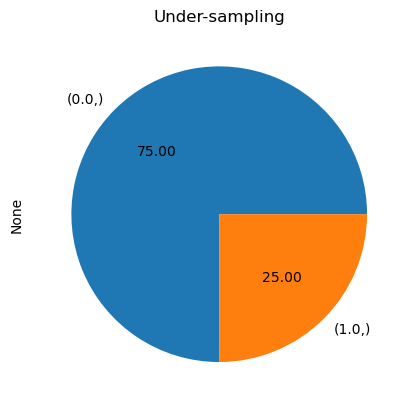

In [67]:
print(y_train.value_counts())
ax = y_train.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

Combine the data back for EDA

In [94]:
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)
combined_df = pd.concat([X_combined, y_combined], axis=1)
combined_df.reset_index(drop=True, inplace=True)

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

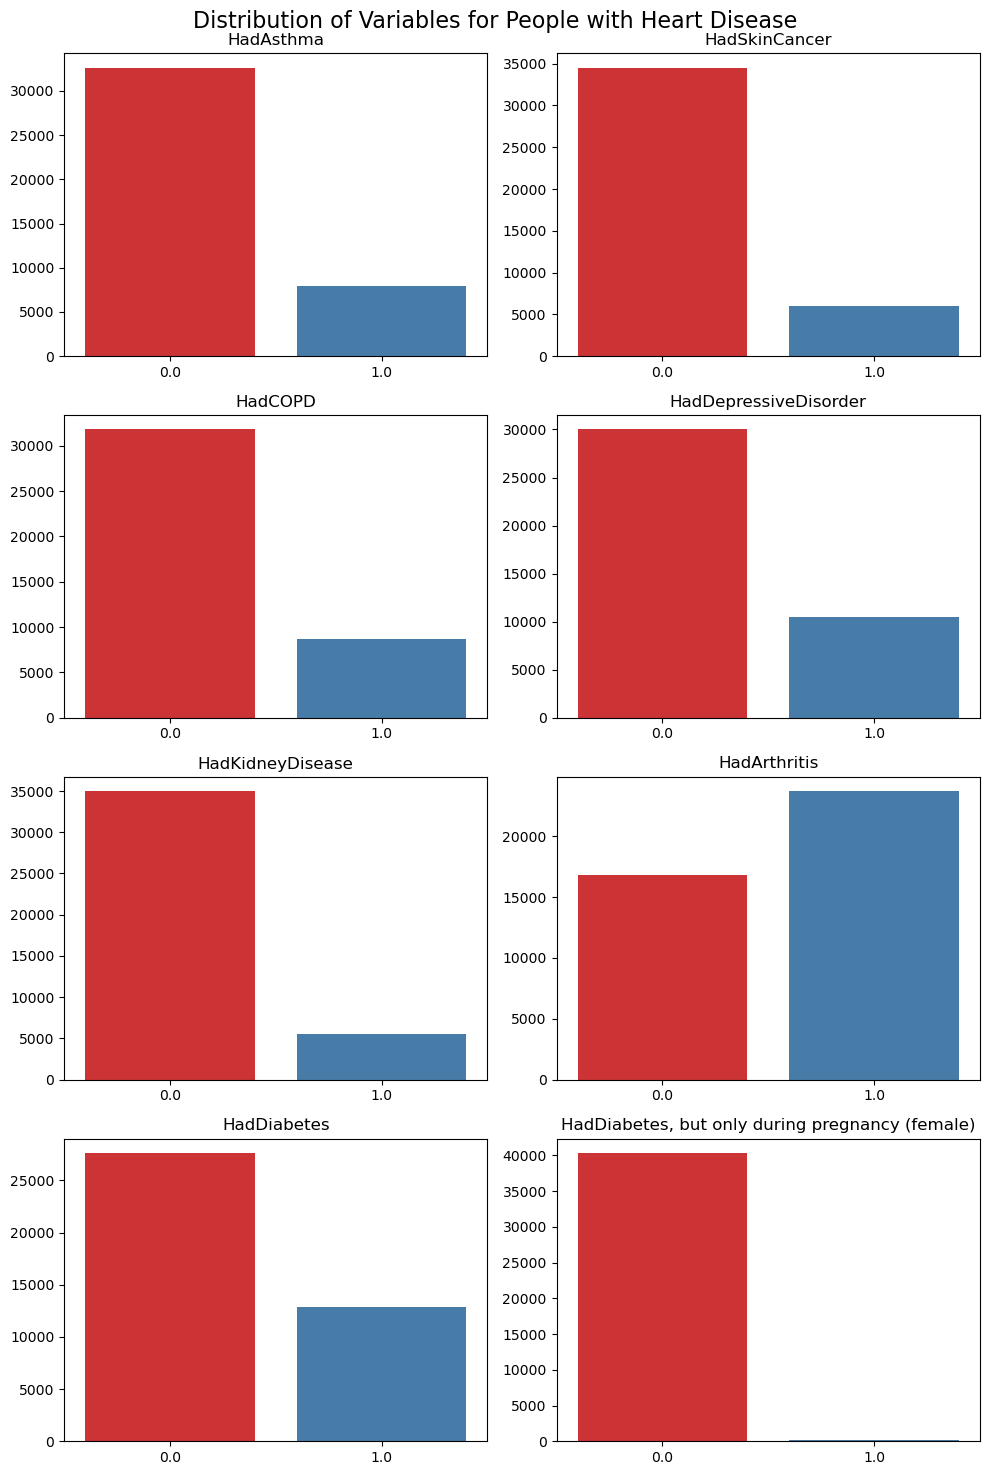

In [122]:
# get all columns that start with "had" and have "yes"
# 1 stands for have disease, 0 stands for no disease
had_cols = [col for col in combined_df.columns if 'Had' in col and 'Yes' in col]
# group dataset by HadHeartDisease
heart_yes = combined_df[combined_df['HadHeartDisease'] == 1]
heart_no = combined_df[combined_df['HadHeartDisease'] == 0]

# plot the distribution of the variables for people who have heart disease
fig, axes = plt.subplots(nrows = 4, ncols = 2)
fig.set_size_inches(10,15)
fig.suptitle('Distribution of Variables for People with Heart Disease', fontsize=16)

for i, col in enumerate(had_cols):
    sns.countplot(heart_yes[col], ax = axes[i//2, i%2], 
                  palette = 'Set1')
    col = col.replace('onehot__', '')
    col = col.replace('_Yes', '')
    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('')
    axes[i//2, i%2].set_ylabel('')
plt.tight_layout()

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

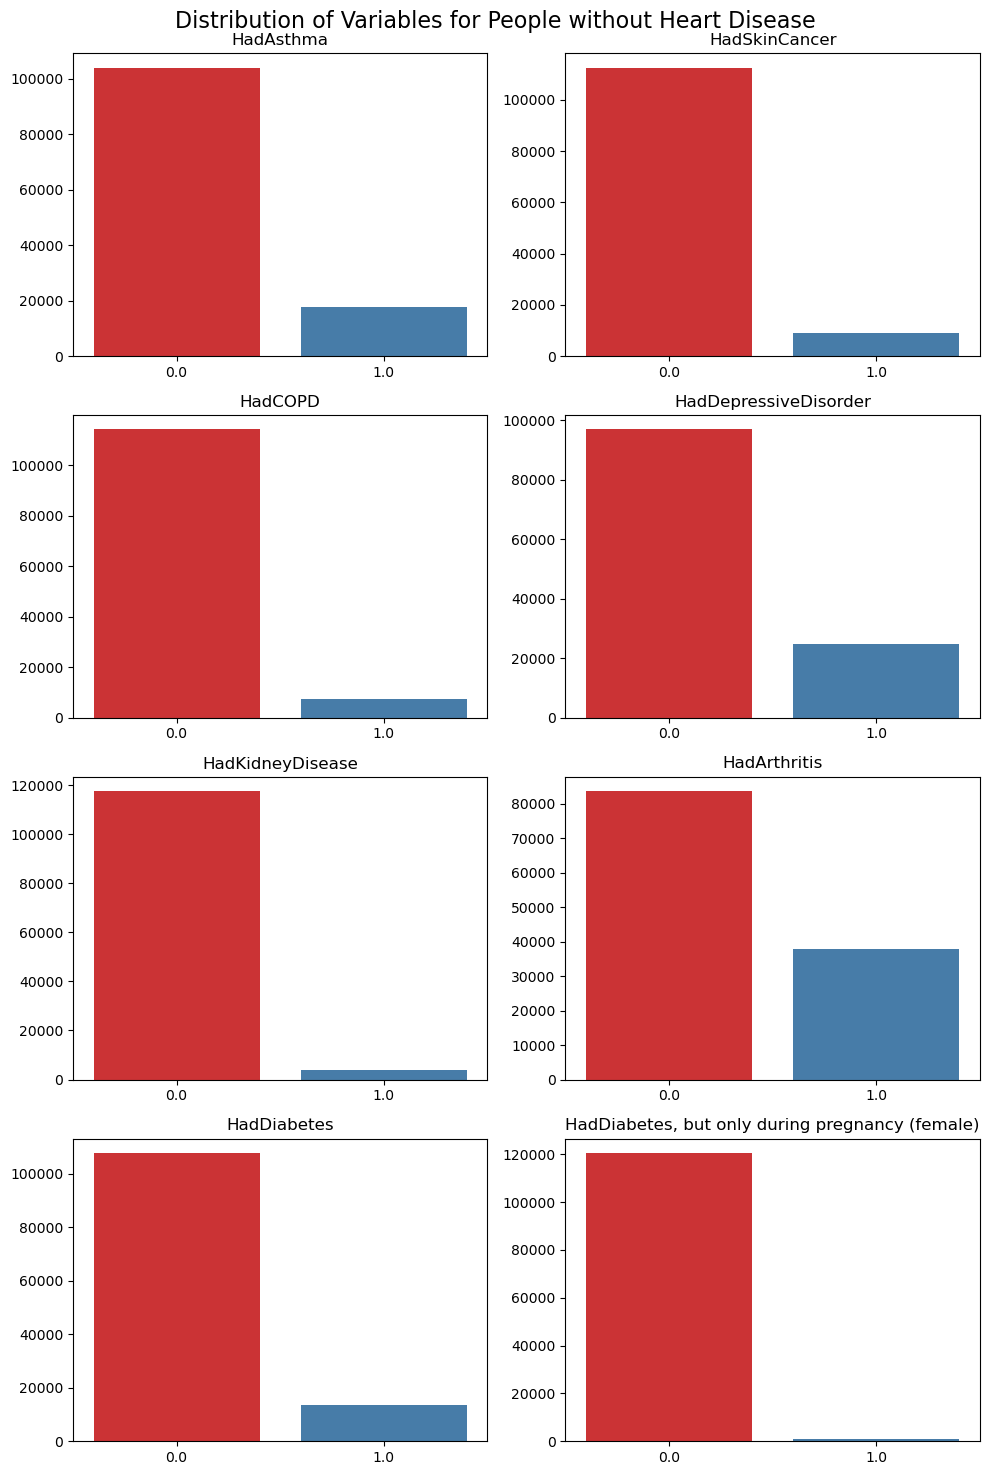

In [123]:
# plot the distribution of the variables for people who DO NOT have heart disease
fig, axes = plt.subplots(nrows = 4, ncols = 2)
fig.set_size_inches(10, 15)
fig.suptitle('Distribution of Variables for People without Heart Disease', fontsize=16)

for i, col in enumerate(had_cols):
    sns.countplot(heart_no[col], ax = axes[i//2, i%2], 
                  palette = 'Set1')
    col = col.replace('onehot__', '')
    col = col.replace('_Yes', '')
    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('')
    axes[i//2, i%2].set_ylabel('')
plt.tight_layout()

['label__AgeCategory']


/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of AgeCategory for People with Heart Disease')

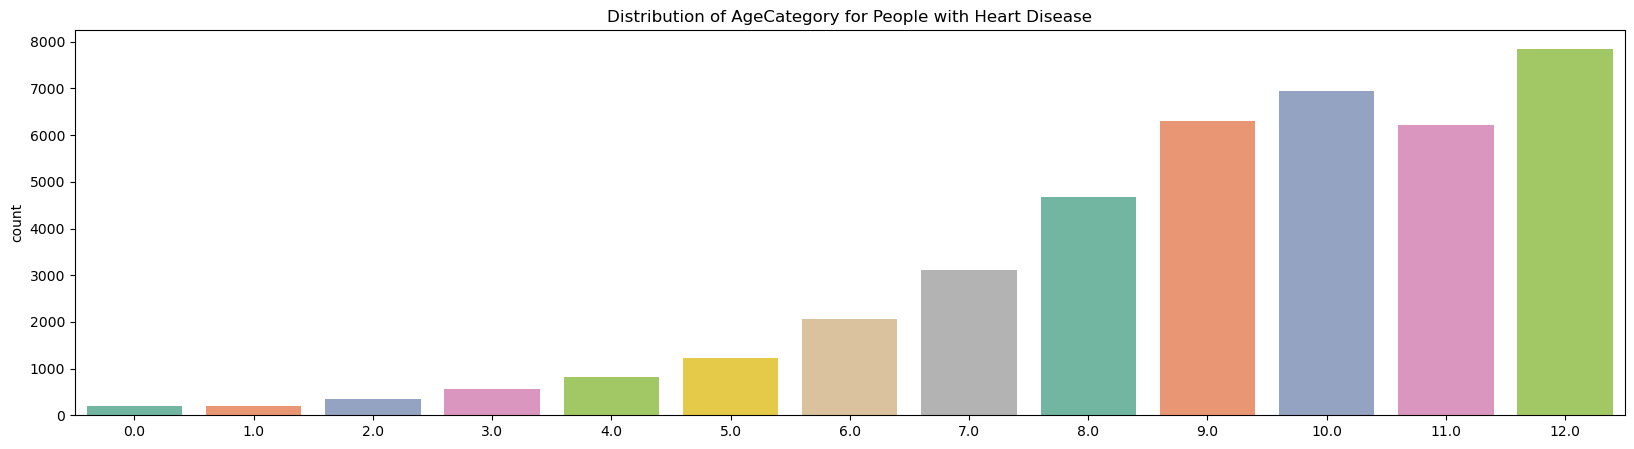

In [124]:
# get all columns that represent an age category
age_cols = [col for col in combined_df.columns if 'AgeCategory' in col]
print(age_cols)
age_yes = combined_df[combined_df['HadHeartDisease'] == 1]['label__AgeCategory']
age_no = combined_df[combined_df['HadHeartDisease'] == 0]['label__AgeCategory']

# see proportion for AgeCategory
plt.figure(figsize=(20,5))
sns.countplot(age_yes, palette = 'Set2')
plt.xlabel('')
plt.title('Distribution of AgeCategory for People with Heart Disease')

/Users/xiaogouzuomeng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of AgeCategory for People without Heart Disease')

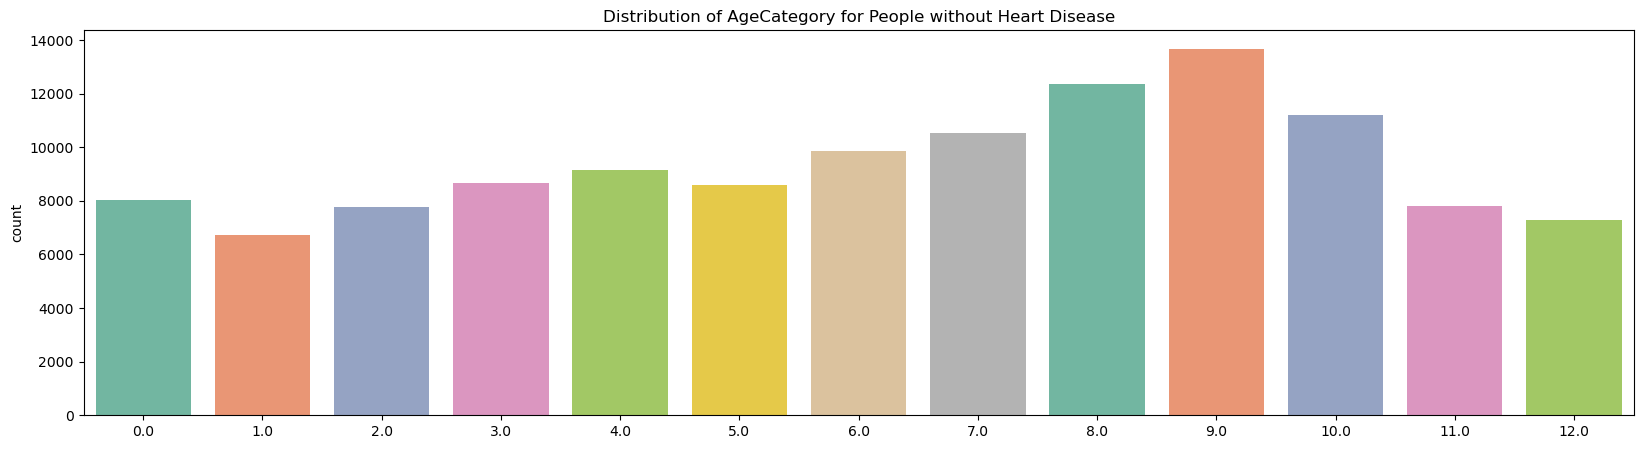

In [125]:
# see proportion for AgeCategory
plt.figure(figsize=(20,5))
sns.countplot(age_no, palette = 'Set2')
plt.xlabel('')
plt.title('Distribution of AgeCategory for People without Heart Disease')